<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/Whole_Brain_500_for_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [1]:
!pip install numpy==1.24.3

In [2]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q

In [3]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.24.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.52.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


##Image, Label and FreeSurferColorLUT Directory

In [5]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [6]:
image_dir = "OASIS_500/Images"
label_dir = "OASIS_500/Labels"

In [7]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [8]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))[:500]
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))[:500]

In [9]:
len(images), len(labels)

(500, 500)

In [10]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[:,:, slice_num], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[:, :,  slice_num, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[:, :, slice_num], cmap = 'gray')
  axs[2].imshow(rgb_img[:, :, slice_num, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




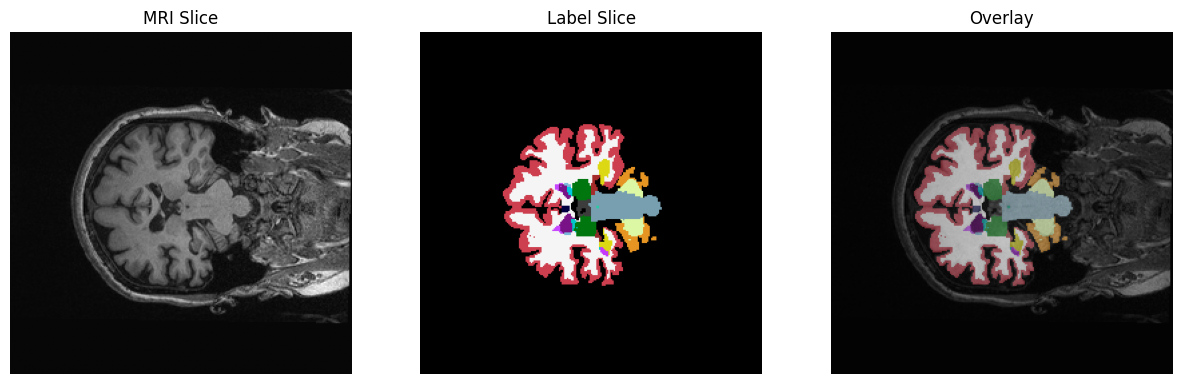

In [11]:
visualize_image(images[245],labels[245], 110)

##Image Transforms and Custom Dataset

####Function to make labels contiguous

In [12]:
def replace_freesurfer_index_with_contiguous(seg):
   label_index=np.unique(seg)
   for items in label_index:
     seg[seg==items]=np.where(label_index==items)[0][0]
   return seg

####Transforms

In [13]:
from monai.transforms import CenterSpatialCrop

In [14]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    CenterSpatialCrop(roi_size=(160, 160, 160)),
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(replace_freesurfer_index_with_contiguous),
    ToTensor(),
    EnsureChannelFirst(),
    CenterSpatialCrop(roi_size=(160, 160, 160)),
])


In [15]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files, val_files = train_test_split(data_dicts[:450], train_size=400, test_size=50, random_state=42)
test_files  = data_dicts[476:491]
len(train_files), len(val_files), len(test_files)

(400, 50, 15)

In [18]:
test_files[0], test_files[14]

({'image': 'OASIS_500/Images/OAS30757_MR_d2279_T1w.nii.gz',
  'label': 'OASIS_500/Labels/OAS30757_MR_d2279_label.nii.gz'},
 {'image': 'OASIS_500/Images/OAS30775_MR_d0183_T1w.nii.gz',
  'label': 'OASIS_500/Labels/OAS30775_MR_d0183_label.nii.gz'})

In [19]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)
test_ds  = MyBrainDataset(test_files,  img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=2)

In [20]:
imgt, segt = test_ds[2]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((160, 160, 160), (160, 160, 160))

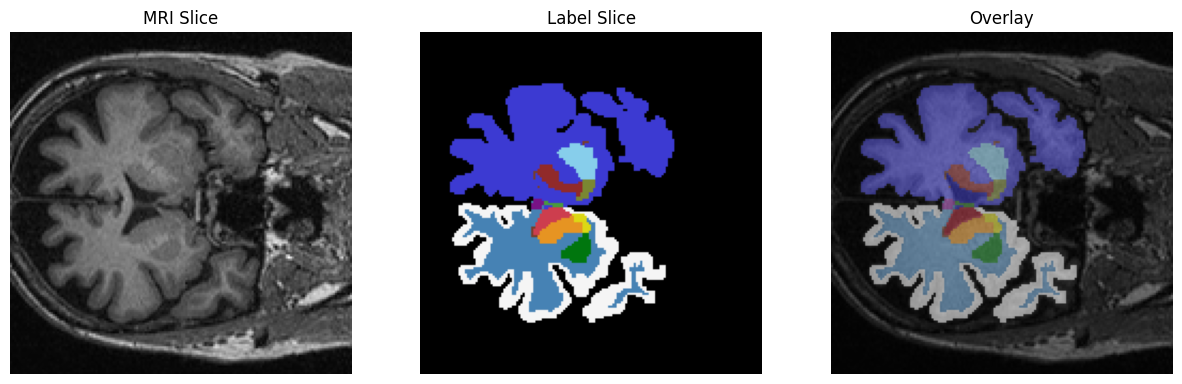

In [21]:
visualize_image(imgt, segt, 100, array = True)

In [22]:
def data_details (train_loader, val_loader, test_loader = None):
  print(f"Number of training samples: {len(train_loader) * train_loader.batch_size}")
  print(f"Number of validation samples: {len(val_loader) * val_loader.batch_size}")
  if test_loader:
    print(f"Number of test samples: {len(test_loader) * test_loader.batch_size}")
  train_batch = next(iter(train_loader))
  train_inputs, _ = train_batch
  print(f"Training input size: {train_inputs.shape}")

In [23]:
data_details(train_loader, val_loader)

Number of training samples: 400
Number of validation samples: 50
Training input size: torch.Size([1, 1, 160, 160, 160])


##Model, Optimizer and Loss Function

In [24]:
from monai.losses import DiceCELoss

In [25]:
set_determinism(seed=40)

num_classes = 45

model = SwinUNETR(
    img_size=(160, 160, 160),
    in_channels=1,
    out_channels=num_classes,
    feature_size=24,
    use_checkpoint=True

).cuda()

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, include_background=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True)
])


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Model Details

In [26]:
#summary(model, input_size=(1, 1, 160, 160, 160))

In [27]:
"""
input_tensor = torch.randn(1, 1, 192, 192, 192)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")
"""

'\ninput_tensor = torch.randn(1, 1, 192, 192, 192)\nflops, params = profile(model, inputs=(input_tensor,))\nprint(f"FLOPs: {flops}")\nprint(f"Parameters: {params}")\n'

##Functions to load and save model and checkpoints

In [28]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [29]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [30]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [31]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    #model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [32]:
"""
def load_model(model, path):
    state_dict = torch.load(path)

    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.endswith('total_ops') and not k.endswith('total_params')}

    model.load_state_dict(filtered_state_dict, strict=False)

    return model

load_model(model, '160_24fs_lr-3_best_dice_model.pth')
"""


"\ndef load_model(model, path):\n    state_dict = torch.load(path)\n\n    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.endswith('total_ops') and not k.endswith('total_params')}\n\n    model.load_state_dict(filtered_state_dict, strict=False)\n\n    return model\n\nload_model(model, '160_24fs_lr-3_best_dice_model.pth')\n"

In [33]:
#epoch, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('160_24fs_lr-3_Checkpoint.pth')

##Epochs and Validation

In [34]:
max_epochs = 50
val_interval = 1

###Run if Checkpoints are not loaded

In [35]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [36]:
from tqdm import tqdm

In [37]:
start_epoch=epoch

In [ ]:
checkpoint_path = '160_24fs_lr-3_temp_Checkpoint.pth'
best_model_path = '160_24fs_lr-3_best_dice_temp_model.pth'

#Training Loop
for epoch in range(start_epoch, max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")

    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")


Epoch [35/50] 2025-03-14 16:36:36.354045


  Train loss: 0.1873


  Validation Dice: 0.8669
Epoch [36/50] 2025-03-14 16:52:08.852598


  3%|▎         | 12/400 [00:28<14:02,  2.17s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f424ea7c040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1603, in __del__
    def __del__(self):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/signal_handling.py", line 73, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 161473) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.


KeyboardInterrupt: 

##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(34, 17, 17)

In [ ]:
max_epochs=34

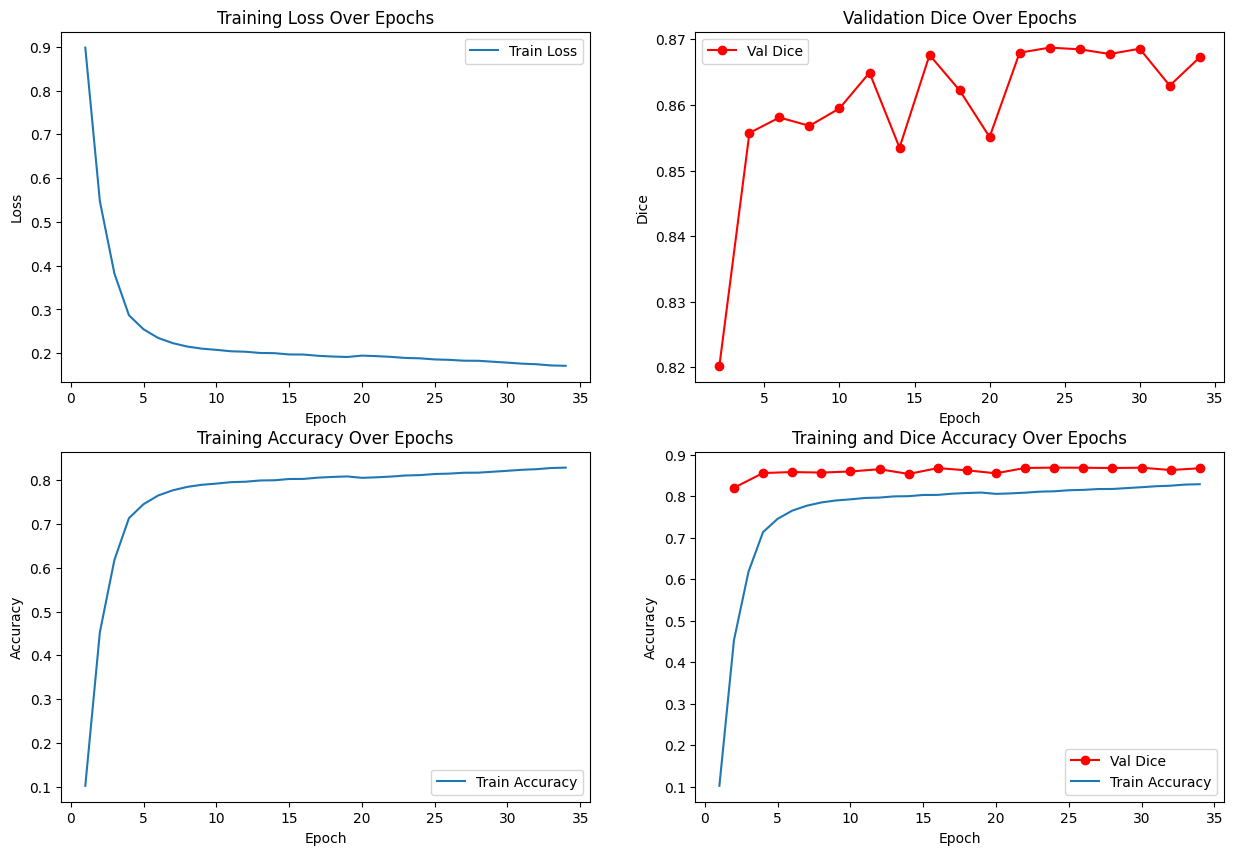

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, 'r-o', label="Val Dice")
axs[1, 1].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

##Model Evaluation

In [ ]:
max(val_dice_list)

0.8687430620193481

In [ ]:
load_model(model, "160_24fs_lr-3_best_dice_model.pth")
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in test_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

Validation Dice: 0.9471
Validation Dice: 0.9363
Validation Dice: 0.9611
Validation Dice: 0.9053
Validation Dice: 0.9302
Validation Dice: 0.9408
Validation Dice: 0.9460
Validation Dice: 0.9236
Validation Dice: 0.9577
Validation Dice: 0.9306
Validation Dice: 0.8687
Validation Dice: 0.8870
Validation Dice: 0.8503
Validation Dice: 0.7763
Validation Dice: 0.9152

Test Dice: 0.9117, Std Dev: 0.0475


In [ ]:

model.eval()

val_img, val_seg = test_ds[1]
val_img_ = val_img.unsqueeze(0).cuda()

with torch.no_grad():
    pred_logits = model(val_img_)

    pred_probs = torch.softmax(pred_logits, dim=1)

    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (160, 160, 160)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44] 45


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  77,  80,
        85, 251, 252, 253, 254, 255])

###Visualization of Predicted and Ground Truth Labels

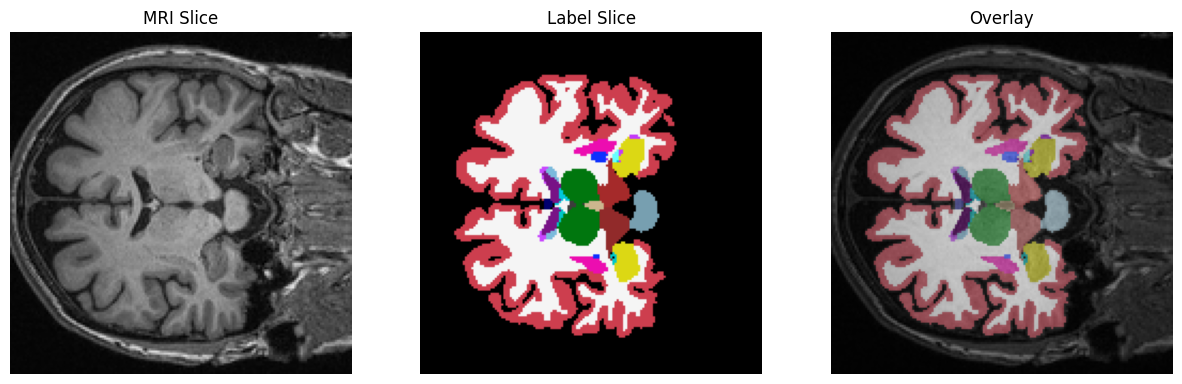

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 75, array = True)

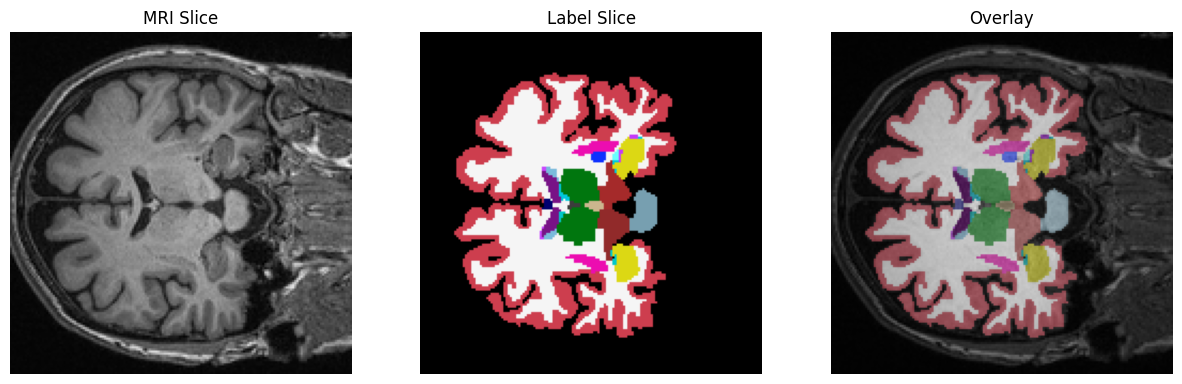

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 75, array = True)

In [ ]:
c=1
req_lbl = [10, 11, 12, 13, 16, 17, 18, 26, 49, 50, 51, 52, 53, 54, 58]
len(req_lbl)

15

In [ ]:
lbl_dir = "MODEL_PREDICTIONS"
os.makedirs(lbl_dir, exist_ok=True)

In [ ]:
model.eval()

for i in range(15):
    val_img, val_seg = test_ds[i]
    val_img_ = val_img.unsqueeze(0).cuda()

    with torch.no_grad():
        pred_logits = model(val_img_)

        pred_probs = torch.softmax(pred_logits, dim=1)

        pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

    pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
    val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
    val_seg_np = val_seg.squeeze().numpy()              # ground truth

    print("Predicted label map shape:", pred_label_np.shape)

    std_pred_lbl = STD_LABEL_VALUES[pred_label_np.astype("int")]

    for j in np.unique(std_pred_lbl):
      if j not in req_lbl:
          std_pred_lbl[std_pred_lbl==j]=0

    affine = np.eye(4)
    new_lbl = nib.Nifti1Image(std_pred_lbl, affine, dtype=np.int16)
    nib.save(new_lbl, os.path.join(lbl_dir, os.path.basename(test_files[i]["label"])))
    print (f"Saved {c} files")
    c+=1

Predicted label map shape: (160, 160, 160)
Saved 1 files
Predicted label map shape: (160, 160, 160)
Saved 2 files
Predicted label map shape: (160, 160, 160)
Saved 3 files
Predicted label map shape: (160, 160, 160)
Saved 4 files
Predicted label map shape: (160, 160, 160)
Saved 5 files
Predicted label map shape: (160, 160, 160)
Saved 6 files
Predicted label map shape: (160, 160, 160)
Saved 7 files
Predicted label map shape: (160, 160, 160)
Saved 8 files
Predicted label map shape: (160, 160, 160)
Saved 9 files
Predicted label map shape: (160, 160, 160)
Saved 10 files
Predicted label map shape: (160, 160, 160)
Saved 11 files
Predicted label map shape: (160, 160, 160)
Saved 12 files
Predicted label map shape: (160, 160, 160)
Saved 13 files
Predicted label map shape: (160, 160, 160)
Saved 14 files
Predicted label map shape: (160, 160, 160)
Saved 15 files


In [ ]:
a = nib.load("MODEL_PREDICTIONS/OAS30757_MR_d2279_label.nii.gz").get_fdata()

In [ ]:
len(np.unique(a))

16